# Taxonomic assignment: Downstream analyses

In [ ]:
# !pip install openpyxl
# !pip install venn

In [1]:
# load modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from venn import venn
from openpyxl.workbook import Workbook

/home/lubo/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# load dataset function

def load_data(marker, cell, sim):
    # loading summary taxonomic assignment table into a dataframes
    raw_data="../raw_data"
    data_path=f"{raw_data}/OTU_summary_tables/otu_summary_table_{marker}_{cell}_{sim}.tsv"
    return pd.read_csv(data_path, sep="\t")

## Summary tables

In [3]:
# load the summary tables into sum_tables dictionary

sum_tables={"cell1_sim97": "", 
          "cell1_sim99": "", 
          "cell2_sim97": "", 
          "cell2_sim99": "",
          "cellCombined_sim97": "",
          "cellCombined_sim99": ""}


for dataset in sum_tables:
    cell, sim = dataset.split("_")
    sum_tables[dataset]=load_data("Full18S", cell, sim)

In [4]:
# save all the summary table as excel tables
marker="Full18S"
data_path="../raw_data/OTU_summary_tables"

for dataset in sum_tables:
    cell, sim = dataset.split("_")
    sum_tables[dataset].to_excel(f"{data_path}/OTU_summary_table_{marker}_{cell}_{sim}.xlsx")

In [5]:
samples=['A3', 'Mock', 'NH1', 'NH4', 'Sim17', 'Sim22', 'Th16', 'Th38',
       'Th40', 'X17007']

# creating a dictonary with sample names where we will store abundance information for each sample
abundance = {}
for sample in samples:
    abundance[sample] = []

# loop through each dataset and calculate number of unique OTUs for each sample
for dataset in sum_tables:
    for sample_name in samples:
        abundance[f'{sample_name}'].append(len(sum_tables[dataset][sum_tables[dataset][f'{sample_name}'] != 0]))
    
unique_otus = pd.DataFrame(data=abundance, index=sum_tables.keys())
unique_otus

,A3,Mock,NH1,NH4,Sim17,Sim22,Th16,Th38,Th40,X17007
cell1_sim97,98,17,66,70,182,103,131,76,104,78
cell1_sim99,96,19,84,104,231,111,141,94,111,62
cell2_sim97,106,16,61,74,193,107,140,81,113,77
cell2_sim99,109,17,78,100,244,115,154,89,115,71
cellCombined_sim97,112,18,76,87,218,125,159,107,127,75
cellCombined_sim99,98,18,92,123,271,134,162,116,131,57


In [6]:
# number of unique OTUs for all samples together
unique_otus["total"] = unique_otus.iloc[0:9].sum(axis=1)
unique_otus

,A3,Mock,NH1,NH4,Sim17,Sim22,Th16,Th38,Th40,X17007,total
cell1_sim97,98,17,66,70,182,103,131,76,104,78,925
cell1_sim99,96,19,84,104,231,111,141,94,111,62,1053
cell2_sim97,106,16,61,74,193,107,140,81,113,77,968
cell2_sim99,109,17,78,100,244,115,154,89,115,71,1092
cellCombined_sim97,112,18,76,87,218,125,159,107,127,75,1104
cellCombined_sim99,98,18,92,123,271,134,162,116,131,57,1202


## Venn diagrams

We want to determine how many OTUs are unique for each dataset (cell1, cell2, and cellCombined), and how many OTUs are shared between the datasets. We will do it for datasets with OTUs created based on 97 and 99 similarity percentage separatelly.

In [7]:
# create a dataset name column for each dataset dataframe

for dataset in sum_tables:
    sum_tables[dataset]["dataset"]=f"{dataset}"

In [8]:
# list of your dataframes
pd_list_97=[sum_tables["cell1_sim97"], sum_tables["cell2_sim97"], sum_tables["cellCombined_sim97"]]
pd_list_99=[sum_tables["cell1_sim99"], sum_tables["cell2_sim99"], sum_tables["cellCombined_sim99"]]

# for dataset in sum_tables:
#     pd_list.append(sum_tables[dataset])

In [9]:
venn_df_97 = pd.concat(pd_list_97)
venn_df_99 = pd.concat(pd_list_99)

In [10]:
# first we need to get the otu table with the occurrence of each biome
otu_cooccurance_97 = pd.crosstab(venn_df_97["ID"], venn_df_97["dataset"]).gt(0).astype(int)
otu_cooccurance_99 = pd.crosstab(venn_df_99["ID"], venn_df_99["dataset"]).gt(0).astype(int)

In [11]:
# now it's ease to find out any combination of the shared OTUs between datasets
# 0 means the OTU is not present and 1 means OTU is present in the given dataset
# if we set one for each dataset, we will filtrate only the unique OTUs that occured in all datasets 

otu_alldatasets_97 = otu_cooccurance_97[(otu_cooccurance_97['cell1_sim97'] == 1) 
                                      & (otu_cooccurance_97['cell2_sim97'] == 1) 
                                      & (otu_cooccurance_97['cellCombined_sim97'] == 1)]

otu_alldatasets_99 = otu_cooccurance_99[(otu_cooccurance_99['cell1_sim99'] == 1) 
                                      & (otu_cooccurance_99['cell2_sim99'] == 1) 
                                      & (otu_cooccurance_99['cellCombined_sim99'] == 1)]

In [ ]:
otu_cooccurance_99['cell1_sim99']

In [12]:
# creating dataset for the venn diagram
venn_datasets_97={}

venn_datasets_97["cell1_sim97"] = set(venn_df_97[venn_df_97.dataset == "cell1_sim97"].to_dict('list')['ID'])
venn_datasets_97["cell2_sim97"] = set(venn_df_97[venn_df_97.dataset == "cell2_sim97"].to_dict('list')['ID'])
venn_datasets_97["cellCombined_sim97"] = set(venn_df_97[venn_df_97.dataset == "cellCombined_sim97"].to_dict('list')['ID'])

venn_datasets_99={}

venn_datasets_99["cell1_sim99"] = set(venn_df_99[venn_df_99.dataset == "cell1_sim99"].to_dict('list')['ID'])
venn_datasets_99["cell2_sim99"] = set(venn_df_99[venn_df_99.dataset == "cell2_sim99"].to_dict('list')['ID'])
venn_datasets_99["cellCombined_sim99"] = set(venn_df_99[venn_df_99.dataset == "cellCombined_sim99"].to_dict('list')['ID'])

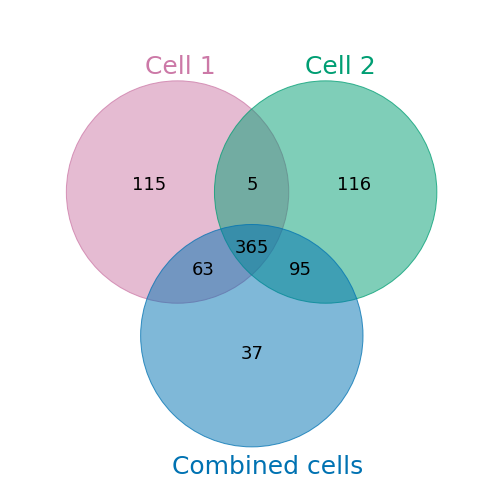

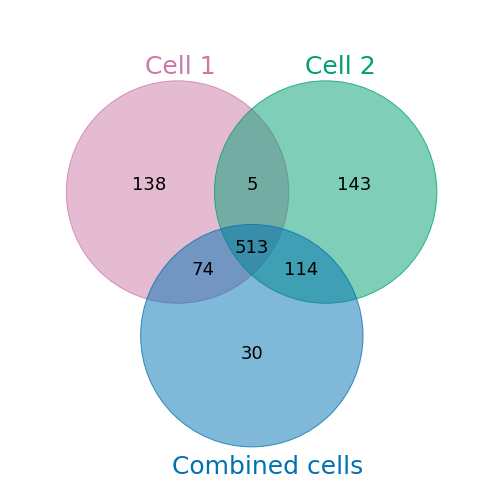

In [171]:
# venn diagram using the pyvenn library: https://pypi.org/project/venn/

from matplotlib.colors import ListedColormap

datasets=[venn_datasets_97, venn_datasets_99]
label=["97", "99"]
path="../raw_data/OTU_summary_tables"

for i in range(2):
    
    fig, ax1 = plt.subplots(figsize=(9, 9), nrows=1, ncols=1)

    c = venn(datasets[i], 
             alpha=0.5, 
             figsize=(10, 5), 
             fontsize=18, 
             legend_loc="upper right", 
             cmap=ListedColormap(["#CC79A7", "#009E73", "#0072B2"]), 
             ax=ax1)


    ax1.get_legend().remove()
    plt.text(0.26, # horizontal
             0.9, # vertical
             "Cell 1", 
             fontsize=25, color='#CC79A7')

    plt.text(
             0.62, # horizontal
             0.9, # vertical
             "Cell 2", 
             fontsize=25, color='#009E73')

    plt.text(
             0.32, # horizontal
             0, # vertical
             "Combined cells", 
             fontsize=25, color='#0072B2')

    # plt.show()

    # save
    plt.savefig(f"{path}/venn_datasets_{label[i]}.png", dpi=300, transparent=False)
    plt.savefig(f"{path}/venn_datasets_{label[i]}.pdf", dpi=300)


## Inspecting how abundances declined through the pipeline (per sample)

Changing number of features (reads, asvs, otus) through the pipeline
Steps in pipelines:
- raw reads
- denoise (filter, denoise, chimeric seqs)
- OTU custering
- otu filter.

### Denoise table

In [14]:
raw_data="../raw_data"
datasets=["cell1", "cell2", "cellCombined"]

df_denoise={}

for dataset in datasets:
    df_denoise[dataset]=pd.read_csv(f"{raw_data}/denoise/Full18S/{dataset}/asv_stats.tsv", sep="\t")
    df_denoise[dataset]=df_denoise[dataset][["sample-id", "input", "primer-removed", "filtered", "denoised", "non-chimeric"]]
    df_denoise[dataset]=df_denoise[dataset].tail(-1)
    df_denoise[dataset]=df_denoise[dataset].rename(columns={"sample-id": "sample_id", "input": "raw_reads", "input": "raw_reads", "filtered": "asv_filtered"})
    id_splited=df_denoise[dataset]['sample_id'].str.split(pat="_", expand=True)
    df_denoise[dataset]["sample_id"]=id_splited[0]
    df_denoise[dataset]=df_denoise[dataset].set_index("sample_id")

In [75]:
df_denoise["cellCombined"]

KeyError: 'cellCombined'

### OTU clustering table

In [15]:
raw_data="../raw_data"
datasets=["cell1", "cell2", "cellCombined"]

df_otu={}

for dataset in datasets:
    df_otu[dataset]=pd.read_csv(f"{raw_data}/OTU_clust/Full18S/{dataset}/sim99/feature_count.tsv", sep="\t")
    id_splited=df_otu[dataset]['Sample_ID'].str.split(pat="_", expand=True)
    df_otu[dataset]['Sample_ID']=id_splited[0]
    df_otu[dataset]=df_otu[dataset].rename(columns={"Sample_ID": "sample_id", "Feature_Count": "otu_clustered"})
    df_otu[dataset]=df_otu[dataset].set_index("sample_id")

In [ ]:
df_otu["cellCombined"]

### OTU filtering table

In [ ]:
# changing number of features (reads, asvs, otus) through the pipeline
# steps in pipelines: raw reads, denoise, otu, otu filter

In [16]:
raw_data="../raw_data"
datasets=["cell1", "cell2", "cellCombined"]

df_otu_filt={}

for dataset in datasets:
    df_otu_filt[dataset]=pd.read_csv(f"{raw_data}/OTU_filtered/Full18S/{dataset}/sim99/feature_count.tsv", sep="\t")
    id_splited=df_otu_filt[dataset]['Sample_ID'].str.split(pat="_", expand=True)
    df_otu_filt[dataset]['Sample_ID']=id_splited[0]
    df_otu_filt[dataset]=df_otu_filt[dataset].rename(columns={"Sample_ID": "sample_id", "Feature_Count": "otu_filt_sim99"})
    df_otu_filt[dataset]=df_otu_filt[dataset].set_index("sample_id")

In [ ]:
df_otu_filt["cellCombined"]

### Merging all tables together

In [17]:
datasets=["cell1", "cell2", "cellCombined"]

df_abundances={}

for dataset in datasets:
    df_abundances[dataset]=df_denoise[dataset] \
    .merge(df_otu[dataset], left_index=True, right_index=True) \
    .merge(df_otu_filt[dataset], left_index=True, right_index=True)
    df_abundances[dataset]=df_abundances[dataset].astype(int)

In [18]:
df_abundances["cellCombined"]

,raw_reads,primer-removed,asv_filtered,denoised,non-chimeric,otu_clustered,otu_filt_sim99
sample_id,,,,,,,
A3,11101,10286,6234,5406,5406,5406,2435
Mock,55734,50839,39196,36400,32983,32983,32180
NH1,17971,16669,11871,8978,8492,8492,7236
NH4,9961,9201,7182,6209,6209,6209,5232
Sim17,32835,30538,24995,21382,21291,21291,13477
Sim22,32423,29778,24600,19900,17659,17659,16735
Th16,24868,22934,18624,14196,13995,13995,12558
Th38,33074,30649,22733,13293,11167,11167,10758
Th40,17934,16496,13769,12880,12880,12880,12101


In [ ]:
# save the final table to an excel file

path="../raw_data/OTU_summary_tables"

with pd.ExcelWriter(f"{path}/abundances.xlsx") as writer:  
    df_abundances["cell1"].to_excel(writer, sheet_name="cell1")
    df_abundances["cell2"].to_excel(writer, sheet_name="cell2")
    df_abundances["cellCombined"].to_excel(writer, sheet_name="cellCombined")

## Inspecting how abundances declined through the pipeline (all samples together)

In [19]:
datasets=["cell1", "cell2", "cellCombined"]

df_abundances_total={}

for dataset in datasets:
    df_abundances_total[dataset] = df_abundances[dataset].sum(axis=0).to_frame().reset_index()
    df_abundances_total[dataset] = df_abundances_total[dataset].rename(columns= {0: 'total'})

In [20]:
df_abundances_total["cell1"]

,index,total
0,raw_reads,125874
1,primer-removed,115973
2,asv_filtered,88379
3,denoised,70120
4,non-chimeric,66797
5,otu_clustered,66797
6,otu_filt_sim99,58423


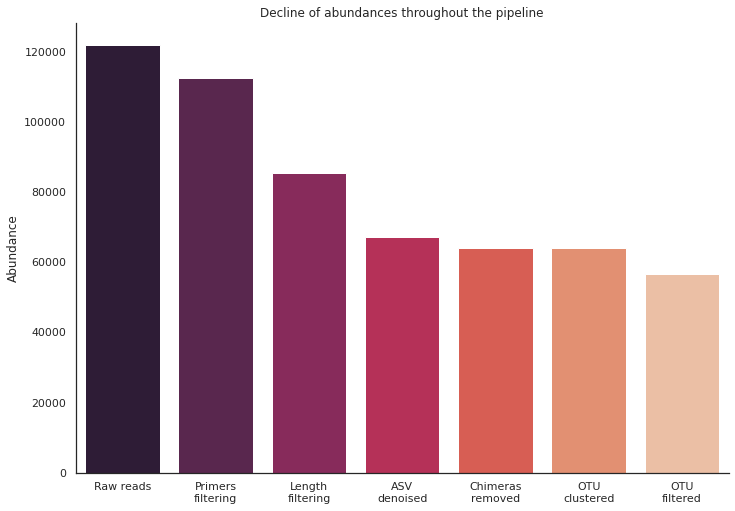

In [21]:
dataset="cell2"
path="../raw_data/OTU_summary_tables"



sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
abund_bar=sns.barplot(x="index", y="total", data=df_abundances_total[dataset], palette="rocket");
abund_bar.set(xlabel="", ylabel = "Abundance", title =f"Decline of abundances throughout the pipeline")
abund_bar.set_xticklabels(["Raw reads", 
                           "Primers\nfiltering", 
                           "Length\nfiltering", 
                           "ASV\ndenoised", 
                           "Chimeras\nremoved",
                           "OTU\nclustered",
                           "OTU\nfiltered"])
sns.despine()

# plt.savefig(f"{path}/abundance_{dataset}.png", dpi=300)

## Reducing number of representative sequences throughout the pipeline

We used three steps that reduce number of the features (representative sequences) in our pipeline:

1. **Denoising raw sequences:** primers and length filtering, denoising, chimeras filtering
2. **OTU clustering:** based on 97 and 99 similarity threshold
3. **OTU filtering:** filtering out taxonomically unassigned OTUs at phyllum level and filtering out rare OTUs

Let's check how many unique number of features was reduced during these three steps.

In [101]:
datasets=["cell1", "cell2", "cellCombined"]
denoise_path="../raw_data/denoise/Full18S"
otu_clust_path="../raw_data/OTU_clust/Full18S"
otu_filt_path="../raw_data/OTU_filtered/Full18S"
sim="sim99"

# creating dictionary where we will append the values in the loop below for our table
rep_seqs_data={"denoised": [],
               "OTU_clustered": [],
               "OTU_filtered": []}

# gathering information for the table
for dataset in datasets:
    
    # gather the total number of unique ASVs
    with open(f"{denoise_path}/{dataset}/asv_seqs.fasta", 'r') as file:
        denoised_fasta = file.read()
    rep_seqs_data["denoised"].append(denoised_fasta.count(">"))
    
    # gather the total number of unique OTUs
    with open(f"{otu_clust_path}/{dataset}/{sim}/otu_seqs.fasta", 'r') as file:
        otu_clust_fasta = file.read()
    rep_seqs_data["OTU_clustered"].append(otu_clust_fasta.count(">"))
    
    # gather the total number of unique OTUs after filtering
    with open(f"{otu_filt_path}/{dataset}/{sim}/otu_seqs_filtered.fasta", 'r') as file:
        otu_filt_fasta = file.read()
    rep_seqs_data["OTU_filtered"].append(otu_filt_fasta.count(">"))
    

# creating the final table that we will populate with data gather in the loop above
rep_seqs=pd.DataFrame(data=rep_seqs_data, index=["cell1", "cell2", "cellCombined"])
rep_seqs

,denoised,OTU_clustered,OTU_filtered
cell1,2447,1929,730
cell2,2302,1843,775
cellCombined,3904,2932,731


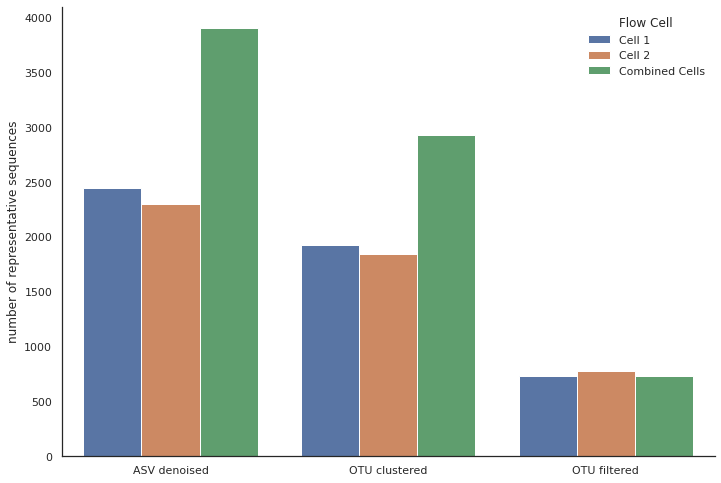

In [165]:
# bar plot of decreasing unique representative sequences after individual steps in the pipeline
path="../raw_data/OTU_summary_tables"

# adjusting the data table for plotting
df_plot=rep_seqs.reset_index()
df_plot=df_plot.melt(id_vars=['index'], value_vars=['denoised', 'OTU_clustered', 'OTU_filtered'])

# plotting code
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
repseq_bar=sns.barplot(data=df_plot, x="variable", y="value", hue="index")
repseq_bar.set(xlabel="", 
                ylabel = "number of representative sequences", 
                title =f"")
repseq_bar.set_xticklabels(["ASV denoised", "OTU clustered", "OTU filtered"])
sns.despine()

# adjusting legend
h, l = repseq_bar.get_legend_handles_labels()
repseq_bar.legend(handles=h, 
                  labels=["Cell 1", "Cell 2", "Combined Cells"], 
                  title='Flow Cell', 
                  loc='upper right', 
                  frameon=False);

# save
plt.savefig(f"{path}/unique_representative_sequences.png", dpi=300)

### Vampyrella specific data

In [ ]:
asv_data

In [ ]:
asv_data.info()

In [ ]:
# vampyrellida ASVs

vamp99 = otu_sim99[otu_sim99['Order'] == 'Vampyrellida']

vamp99[['ID', 'Total', 'A3', 'Mock', 'NH1', 'NH4', 'Sim17', 'Sim22', 'Th16',
   'Th38', 'Th40', 'X17007', 'Order', 'Family', 'Genus', 'Species', 
   'Percent_similarity']]

In [ ]:
vamp99[vamp99['Mock'] != 0]